# Import relevant libraries/modules etc

In [1]:
import numpy as np
import xarray as xr
import rasterio
%matplotlib inline
from matplotlib.pyplot import *
from glob import glob
import os
import datetime
import pandas as pd
from rasterio_to_xarray import rasterio_to_xarray, xarray_to_rasterio

# Create an array with MAIAC data

- create a function which reads in the files, determines the no data values, and creates a third dim 'time'
- create a list with all of the files to be put in the 3d array
- run the function on every element of list (map)

In [2]:
def maiac_file_to_da(filename):
    da = rasterio_to_xarray(filename)
    
    time_str = os.path.basename(filename)[17:-13]
    time_obj = datetime.datetime.strptime(time_str, '%Y%j%H%M')
    da.coords['time'] = time_obj
    
    return da

In [3]:
files = glob(r'D:\Annies_Dissertation\MAIAC_Test\Projected\2014\*_proj.tif')

In [4]:
list_of_das = map(maiac_file_to_da, files)

In [5]:
MAIAC_AOT = xr.concat(list_of_das, 'time')

In [ ]:
- view the dataset
- view the different 3D timestamps

In [6]:
MAIAC_AOT

<xarray.DataArray (time: 23, y: 1162, x: 1240)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  

In [7]:
MAIAC_AOT.time

<xarray.DataArray 'time' (time: 23)>
array(['2014-01-01T12:55:00.000000000', '2014-01-01T14:30:00.000000000',
       '2014-01-02T12:00:00.000000000', '2014-01-02T13:35:00.000000000',
       '2014-01-03T12:40:00.000000000', '2014-01-03T14:20:00.000000000',
       '2014-01-04T11:45:00.000000000', '2014-01-04T13:25:00.000000000',
       '2014-01-04T15:05:00.000000000', '2014-01-05T12:30:00.000000000',
       '2014-01-05T14:10:00.000000000', '2014-01-06T11:35:00.000000000',
       '2014-01-06T13:10:00.000000000', '2014-01-06T14:50:00.000000000',
       '2014-01-07T12:15:00.000000000', '2014-01-07T13:55:00.000000000',
       '2014-01-08T13:00:00.000000000', '2014-01-08T14:40:00.000000000',
       '2014-01-09T12:05:00.000000000', '2014-01-09T13:45:00.000000000',
       '2014-01-10T12:45:00.000000000', '2014-01-10T14:25:00.000000000',
       '2014-01-11T11:50:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01T12:55:00 2014-01-01T14:30:00 ...

# Group data
- merge multiple images per day using the maximum AOT estimates

In [9]:
Daily_MAIAC_AOT = MAIAC_AOT.resample('D', dim='time', how='max')

In [10]:
Daily_MAIAC_AOT

<xarray.DataArray (time: 11, y: 1162, x: 1240)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  

# Analysis
## overall average of every pixel

In [11]:
overall_mean = Daily_MAIAC_AOT.mean(dim='time', keep_attrs=True)

In [12]:
overall_mean.attrs

OrderedDict([('affine',
              Affine(1256.5430440955893, 0.0, -947639.6305106478,
       0.0, -1256.5430440955893, 1429277.8120091767)),
             ('crs', CRS({'init': 'epsg:27700'}))])

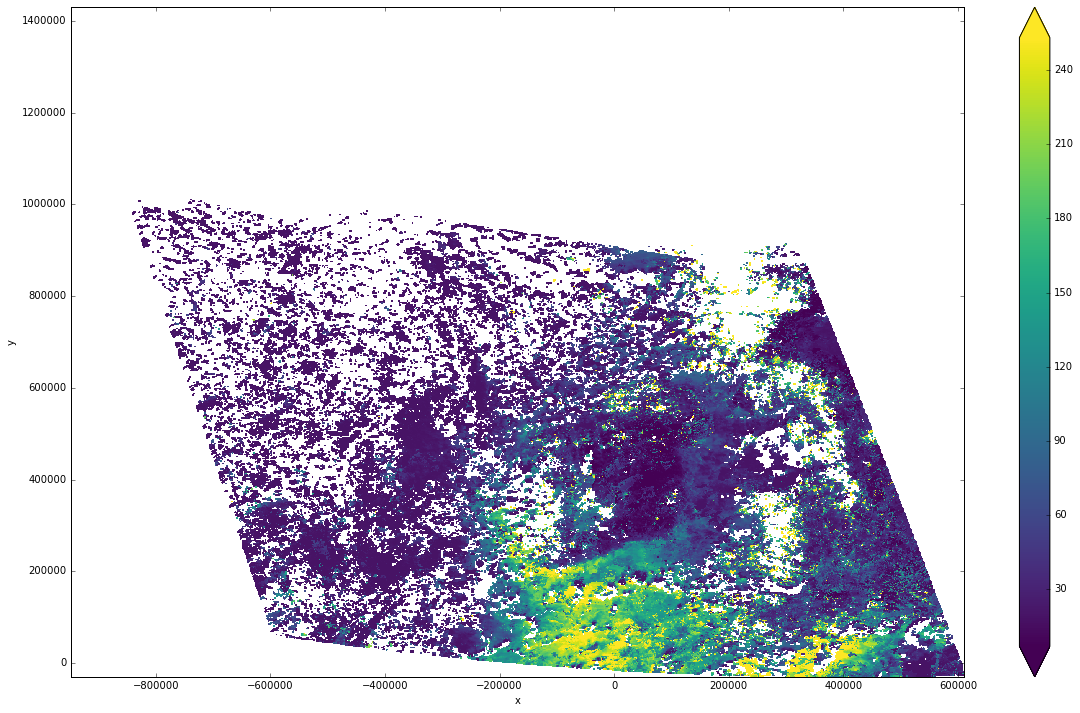

In [13]:
figure(figsize=(20, 12))
overall_mean.plot(robust=True)

In [31]:
xarray_to_rasterio(overall_mean, r'D:\Annies_Dissertation\MAIAC_Test\Projected\2014\overall_mean_out.tif')

## Time series over one pixel
- get the information (time series) over one pixel
- validate against AERONET Chibolton site

In [ ]:
Chilbolton = res.isel(x=1103, y=1027).dropna('time').to_pandas()

In [ ]:
Chilbolton

In [ ]:
Chil_AOT = Chilbolton/1000

In [ ]:
Chil_AOT

In [ ]:
Chil_AOT.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\Comparision\MAIAC\Chilbolton_AOT_MAIAC.csv')

## Averages
### Monthly

In [53]:
monthly = r.groupby('time.month').max(dim='time')

In [54]:
monthly.coords

Coordinates:
  * x        (x) float64 -9.476e+05 -9.464e+05 -9.451e+05 -9.439e+05 ...
  * y        (y) float64 1.429e+06 1.428e+06 1.427e+06 1.426e+06 1.424e+06 ...
  * month    (month) int64 1

In [ ]:
figure(figsize=(20, 12))
monthly.plot(col='month', robust=True)

### Seasonal

In [56]:
seasonal = r.groupby('time.season').max(dim='time')

In [57]:
seasonal.coords

Coordinates:
  * x        (x) float64 -9.476e+05 -9.464e+05 -9.451e+05 -9.439e+05 ...
  * y        (y) float64 1.429e+06 1.428e+06 1.427e+06 1.426e+06 1.424e+06 ...
  * season   (season) object 'DJF'

In [ ]:
figure(figsize=(20, 12))
season.plot(col='season', robust=True)

### Yearly

In [ ]:
yearly = r.groupby('date.year').max(dim='date')

In [ ]:
yearly.coords

In [ ]:
figure(figsize=(20, 12))
yearly.plot(col='year', robust=True)

# Count of values that aren't missing

In [16]:
observations = r.count(dim='date')

(array([  1.11791600e+06,   0.00000000e+00,   2.16945000e+05,
          0.00000000e+00,   8.35610000e+04,   0.00000000e+00,
          1.94620000e+04,   0.00000000e+00,   2.91600000e+03,
          8.00000000e+01]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 10 Patch objects>)

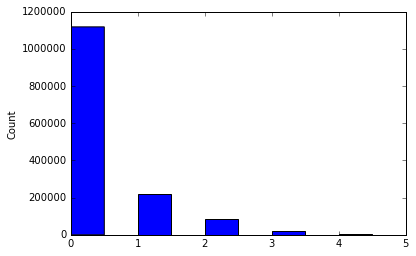

In [17]:
observations.plot.hist()

# Validation- getting pixel

In [84]:
r.sel(x=439480.737, y=138506.177, method='nearest')

<xarray.DataArray (time: 11)>
array([ nan,  47.,  80.,  nan,  nan,  nan,  66.,  nan,  nan,  nan,  nan], dtype=float32)
Coordinates:
    x        float64 4.396e+05
    y        float64 1.388e+05
  * time     (time) datetime64[ns] 2014-01-01 2014-01-02 2014-01-03 ...
Attributes:
    crs: CRS({'init': 'epsg:27700'})
    affine: | 1256.54, 0.00,-947639.63|
| 0.00,-1256.54, 1429277.81|
| 0.00, 0.00, 1.00|

In [81]:
xarray_to_rasterio(r, r'D:\Annies_Dissertation\Methodology\Validation\testrobin.tif')

In [87]:
a = r.attrs['affine']

Once you've got a location in OS co-ordinates, you can use this code, with the coords in (x, y)

In [89]:
~a * (439480.737, 138506.177)

(1103.917907172884, 1027.240285220968)

In [93]:
a * (0, 1027)

(-947639.6305106478, 1429277.8120091767)

In [90]:
r.isel(x=1103, y=1027)

<xarray.DataArray (time: 11)>
array([  nan,   47.,   79.,   nan,   nan,   nan,  180.,   nan,   nan,
         nan,   nan], dtype=float32)
Coordinates:
    x        float64 4.383e+05
    y        float64 1.388e+05
  * time     (time) datetime64[ns] 2014-01-01 2014-01-02 2014-01-03 ...
Attributes:
    crs: CRS({'init': 'epsg:27700'})
    affine: | 1256.54, 0.00,-947639.63|
| 0.00,-1256.54, 1429277.81|
| 0.00, 0.00, 1.00|